**Set environment**

In [1]:
suppressMessages(source("../config_sing.R"))

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /mount/work 
PATH OF SOURCE:     /mount/work/source 
PATH OF EXECUTABLE: /mount/work/exe 
PATH OF ANNOTATION: /mount/work/annotation 
PATH OF PROJECT:    /mount/project 
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc 


## Import data

**Tiling MPRA**

In [2]:
fdiry = file.path(FD_RES, "Tewhey_K562_TileMPRA", "count")
dir(fdiry)

[1] "Tile_K562_20210130.GATA1.unstranded.bed"

In [3]:
### set file path
fdiry = file.path(FD_RES, "Tewhey_K562_TileMPRA", "count")
fname = "Tile_K562_20210130.GATA1.unstranded.bed"
fpath = file.path(fdiry, fname)

### set columns
cnames = c("chrom", "Start", "End", "ID", "Score", "Strand", 
           "log2fc", "Input_Count", "Output_Count", 
           "log10pval", "log10fdr", "lfc_se")

### read data
dat = read_tsv(fpath, col_names = cnames, show_col_types = FALSE)
dat = dat %>% mutate(Loc = (Start + End) / 2)

### assign and show
dat_tmpra = dat
head(dat_tmpra)

chrom,Start,End,ID,Score,Strand,log2fc,Input_Count,Output_Count,log10pval,log10fdr,lfc_se,Loc
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX,47786401,47786600,X:47786401-47786600,.,+,2.30593934,2117.787,10474.869,112.1126526,110.93113079,0.10214790,47786500
chrX,47786451,47786650,X:47786451-47786650,.,+,0.78305606,1386.007,2387.119,11.3173884,10.64251685,0.11330705,47786550
chrX,47786501,47786700,X:47786501-47786700,.,+,-0.12873196,1955.626,1788.236,0.8450697,0.62872262,0.08785968,47786600
chrX,47786551,47786750,X:47786551-47786750,.,+,0.58829515,2388.997,3591.264,11.2404554,10.56667887,0.08543661,47786650
chrX,47786601,47786800,X:47786601-47786800,.,+,0.06670014,2102.916,2202.385,0.3095900,0.21047015,0.09667741,47786700
chrX,47786651,47786850,X:47786651-47786850,.,+,-0.02967703,1571.259,1537.475,0.1009399,0.06453099,0.11287406,47786750


**ATAC-STARR**

In [4]:
### set file path
fdiry = file.path(FD_RES, "KS91_K562_ASTARRseq", "coverage")
fname = "KS91_K562_hg38_ASTARRseq_Ratio.GATA1.unstranded.perbase.tsv"
fpath = file.path(fdiry, fname)

### set column
ctypes = c(col_integer(), col_double(), col_double(), col_double())

### read data and show
dat_astarr = read_tsv(fpath, col_types = ctypes)
head(dat_astarr)

Loc,Input,Output,Ratio
<dbl>,<dbl>,<dbl>,<dbl>
47786400,0,0,0
47786401,0,0,0
47786402,0,0,0
47786403,0,0,0
47786404,0,0,0
47786405,0,0,0


In [5]:
print(range(dat_astarr$Loc))
print(range(dat_tmpra$Loc))
print(range(dat_tmpra$Start))
print(range(dat_tmpra$End))

[1] 47786400 49786749
[1] 47786500 49786650
[1] 47786401 49786551
[1] 47786600 49786750


## Zoom-In: ChrX:48,780,000-48,826,000

In [11]:
### set bins
start  = 48780000
end    = 48826000
size   = 100
breaks = seq(start, end, size)

### binning the data
df1 = dat_astarr
df1$group = cut(df1$Loc, breaks=breaks, right = FALSE, dig.lab = 10)

df2 = dat_tmpra 
df2$group = cut(df2$Loc, breaks=breaks, right = FALSE, dig.lab = 10)

### summarize the ratio
df1 = df1 %>% group_by(group) %>% summarize(Val = sum(Ratio))     %>% na.omit
df2 = df2 %>% group_by(group) %>% summarize(Val = sum(2**log2fc)) %>% na.omit

### separate bin label to left and right bound
df1 = df1 %>% 
    mutate(group = gsub("\\[|\\)", "", group)) %>%
    separate(group, c("Left", "Right")) %>%
    mutate(Left = as.integer(Left), Right = as.integer(Right))

df2 = df2 %>% 
    mutate(group = gsub("\\[|\\)", "", group)) %>%
    separate(group, c("Left", "Right")) %>%
    mutate(Left = as.integer(Left), Right = as.integer(Right))

### show results
cat("ASTARR", dim(df1), "\n")
print(head(df1, 3))
cat("\n")
cat("Tiling MPRA", dim(df2), "\n")
print(head(df2, 3))

ASTARR 460 3 
# A tibble: 3 × 3
      Left    Right    Val
     <int>    <int>  <dbl>
1 48780000 48780100 0.0423
2 48780100 48780200 0.0426
3 48780200 48780300 0.0276

Tiling MPRA 459 3 
# A tibble: 3 × 3
      Left    Right   Val
     <int>    <int> <dbl>
1 48780000 48780100  2.01
2 48780100 48780200  2.33
3 48780200 48780300  1.68


**Plot**

In [12]:
### create figure
dat = df1
gp1 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=Val)) +
    labs(y="Ratio", title="ATAC-STARR-seq") +
    theme_cowplot()

In [13]:
### create figure
dat = df2
gp2 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=Val)) +
labs(y="Ratio", title="Tiling MPRA") +
    theme_cowplot()

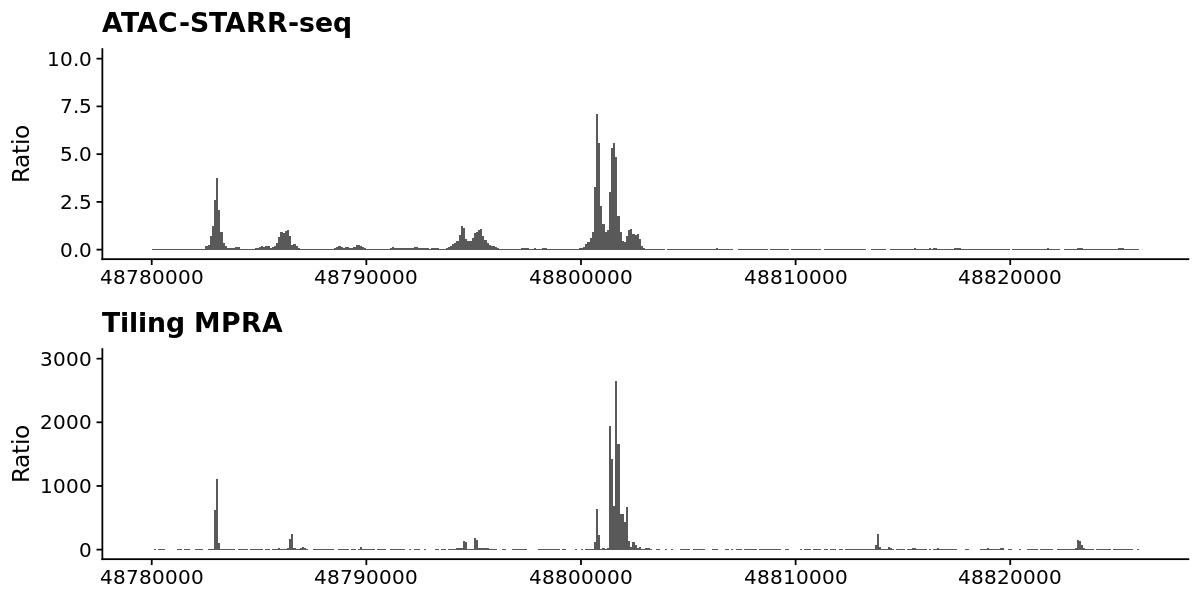

In [15]:
options(repr.plot.height=5, repr.plot.width=10)
plot_grid(
    gp1 + ylim(0, 10), 
    gp2 + ylim(0, 3000), 
    align="v", 
    nrow=2, 
    ncol=1)

**Plot (Log scale)**

In [61]:
### create figure
dat = df1
gp1 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=log2(Val))) +
    theme_cowplot()

In [62]:
### create figure
dat = df2
gp2 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=log2(Val))) +
    theme_cowplot()

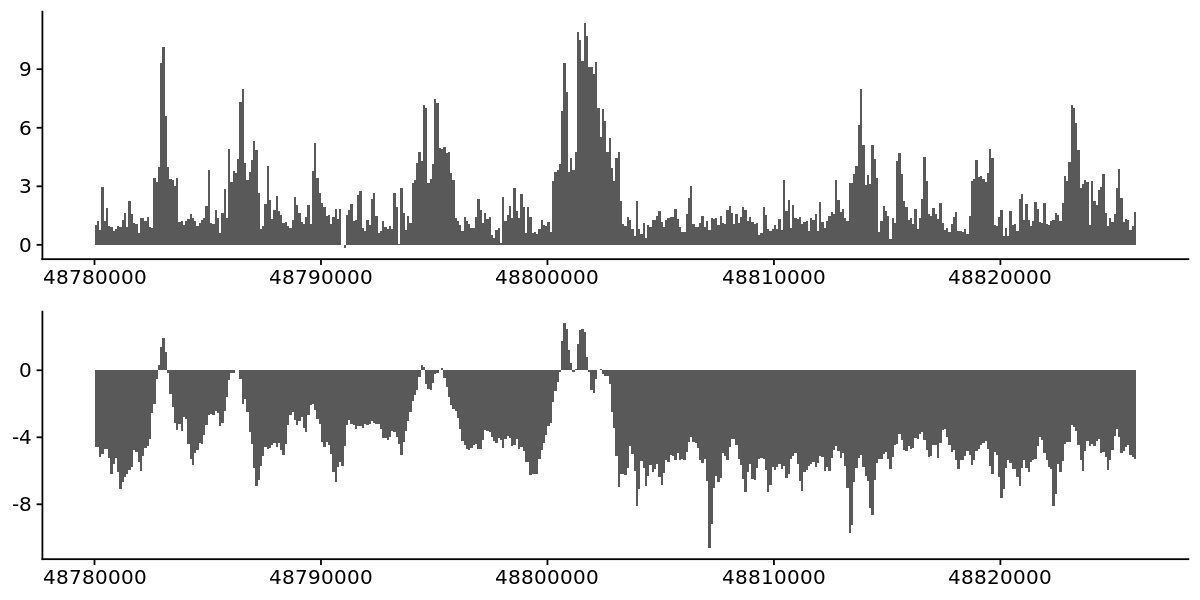

In [63]:
options(repr.plot.height=5, repr.plot.width=10)
plot_grid(
    gp1 , 
    gp2 , 
    align="v", 
    nrow=2, 
    ncol=1)

## Plot whole

In [87]:
### set bins
start  = 47786400
end    = 49786800
size   = 5000
breaks = seq(start, end, size)

### binning the data
df1 = dat_mpra 
df1$group = cut(df1$Loc, breaks=breaks, right = FALSE, dig.lab = 10)

df2 = dat_astarr
df2$group = cut(df2$Loc, breaks=breaks, right = FALSE, dig.lab = 10)

### summarize the ratio
df1 = df1 %>% group_by(group) %>% summarize(Val = sum(2**log2fc)) %>% na.omit
df2 = df2 %>% group_by(group) %>% summarize(Val = sum(Ratio))     %>% na.omit

### separate bin label to left and right bound
df1 = df1 %>% 
    mutate(group = gsub("\\[|\\)", "", group)) %>%
    separate(group, c("Left", "Right")) %>%
    mutate(Left = as.integer(Left), Right = as.integer(Right))

df2 = df2 %>% 
    mutate(group = gsub("\\[|\\)", "", group)) %>%
    separate(group, c("Left", "Right")) %>%
    mutate(Left = as.integer(Left), Right = as.integer(Right))

### show results
cat("Tiling MPRA", dim(df1), "\n")
print(head(df1, 3))
cat("\n")
cat("ASTARR", dim(df2), "\n")
print(head(df2, 3))

Tiling MPRA 365 3 
# A tibble: 3 × 3
      Left    Right   Val
     <int>    <int> <dbl>
1 47786400 47791400  212.
2 47791400 47796400  114.
3 47796400 47801400  194.

ASTARR 400 3 
# A tibble: 3 × 3
      Left    Right   Val
     <int>    <int> <dbl>
1 47786400 47791400 0.369
2 47791400 47796400 0.319
3 47796400 47801400 1.43 


In [88]:
### create figure
dat = df1
gp1 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=Val)) +
    theme_cowplot()

In [89]:
### create figure
dat = df2
gp2 = ggplot(dat) + 
    geom_rect(
        mapping=aes(
            xmin=Left, 
            xmax=Right, 
            ymin=0, 
            ymax=Val)) +
    theme_cowplot()

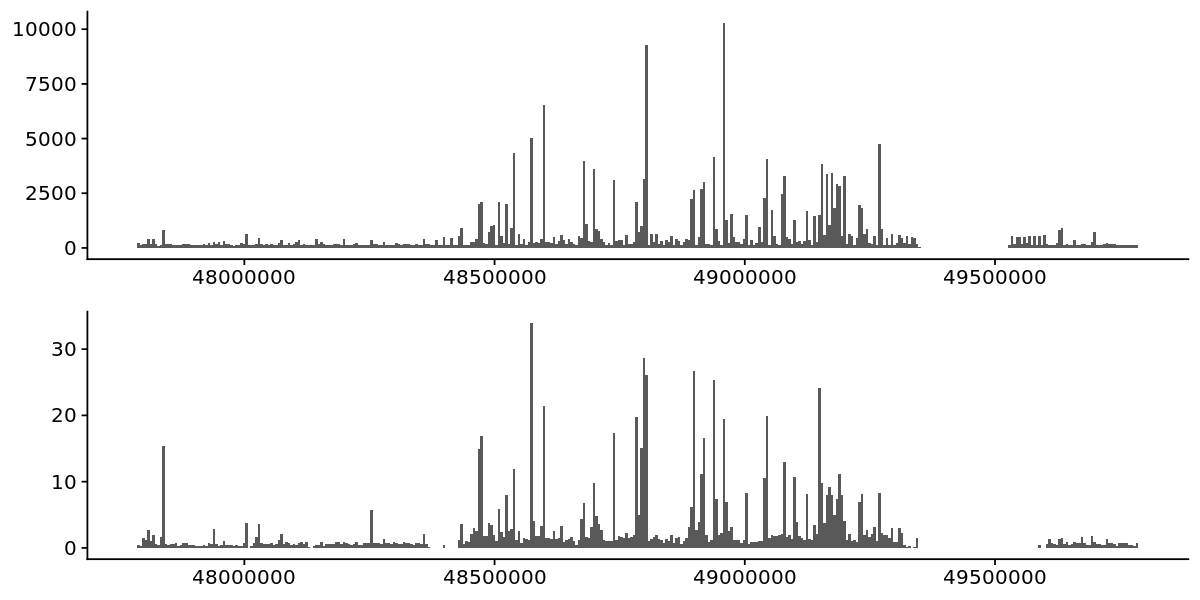

In [90]:
options(repr.plot.height=5, repr.plot.width=10)
plot_grid(
    gp1,#+ ylim(0, 8000), 
    gp2,# + ylim(0, 50), 
    align="v", 
    nrow=2, 
    ncol=1)